# Student Profile

Github Profile: https://github.com/franva

AIStudio Profile: https://aistudio.baidu.com/aistudio/personalcenter/thirdview/710090

QQ: 西域大菠菜

# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [1]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
2021-04-18 22:22:46,424 - INFO - font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/co

### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='400px' width='900px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [ ]:
# 解压数据
!unzip -q data/data79149/cartoon_A2B.zip -d data/

### 数据可视化

训练集数据量: 1361
测试集数据量: 100


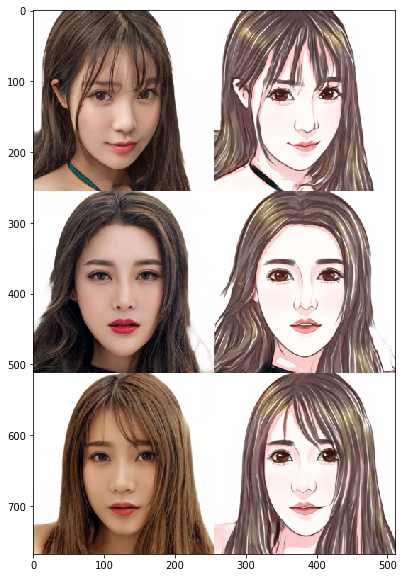

In [ ]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

# the imgs are BGR, change them to RGB
img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [ ]:
# Normally, I'd like to see the shape of the data
iss = np.array(imgs)
iss.shape

(3, 256, 512, 3)

In [ ]:
# And let's also take a look at what the stacked img_show looks like
(img_show).shape

(768, 512, 3)

In [ ]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])     # 读取一组数据
        img_A2B = img_A2B.astype('float32') / 127.5 - 1.  # 从0~255归一化至-1~1
        img_A2B = img_A2B.transpose(2, 0, 1)              # 维度变换HWC -> CHW
        img_A = img_A2B[..., :256]                        # 真人照
        img_B = img_A2B[..., 256:]                        # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]

In [ ]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

## 第一步：搭建生成器

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [ ]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim)
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [ ]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=True),
            nn.BatchNorm2D(out_dim),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()

In [ ]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30]

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


In [10]:
# 超参数
LR = 1e-5
BATCH_SIZE = 68
EPOCHS = 200

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

In [11]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

In [12]:
for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        real_A, real_B = data
        
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A).detach()
        fake_AB = paddle.concat((real_A, fake_B), 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat([real_A, fake_B], 1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_B, real_B) * 100.
        g_loss = g_bce_loss + g_l1_loss
        
        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()


100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/200] Loss D: [0.535389], Loss G: [51.021206]



100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/200] Loss D: [0.47413826], Loss G: [47.460564]



100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/200] Loss D: [0.42012694], Loss G: [42.9087]



100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/200] Loss D: [0.37928486], Loss G: [40.790974]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/200] Loss D: [0.33729416], Loss G: [38.95559]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/200] Loss D: [0.3157989], Loss G: [36.226856]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/200] Loss D: [0.30574524], Loss G: [34.67221]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/200] Loss D: [0.30971485], Loss G: [32.24821]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/200] Loss D: [0.28765693], Loss G: [31.000175]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Epoch [10/200] Loss D: [0.2658624], Loss G: [30.107317]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/200] Loss D: [0.25841734], Loss G: [28.107038]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/200] Loss D: [0.24169067], Loss G: [27.362673]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/200] Loss D: [0.23848683], Loss G: [26.130182]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/200] Loss D: [0.2319244], Loss G: [25.205202]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/200] Loss D: [0.23304532], Loss G: [24.102291]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/200] Loss D: [0.2437138], Loss G: [23.15854]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/200] Loss D: [0.2447178], Loss G: [22.594782]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/200] Loss D: [0.23193657], Loss G: [22.268185]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/200] Loss D: [0.23540713], Loss G: [21.534954]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch [20/200] Loss D: [0.24763404], Loss G: [21.036955]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/200] Loss D: [0.23913169], Loss G: [20.211407]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/200] Loss D: [0.24036822], Loss G: [19.926228]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/200] Loss D: [0.24334481], Loss G: [19.358198]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/200] Loss D: [0.27423316], Loss G: [18.889683]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/200] Loss D: [0.25917587], Loss G: [18.184006]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/200] Loss D: [0.25783607], Loss G: [17.990936]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/200] Loss D: [0.2668255], Loss G: [17.732603]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/200] Loss D: [0.28437197], Loss G: [17.557425]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/200] Loss D: [0.2891405], Loss G: [16.665829]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Epoch [30/200] Loss D: [0.29520947], Loss G: [16.700768]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/200] Loss D: [0.30444694], Loss G: [16.300152]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/200] Loss D: [0.3421303], Loss G: [15.824135]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/200] Loss D: [0.35768807], Loss G: [16.017948]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/200] Loss D: [0.3360355], Loss G: [15.353802]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/200] Loss D: [0.34713343], Loss G: [15.341348]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/200] Loss D: [0.3983901], Loss G: [15.285606]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/200] Loss D: [0.38518143], Loss G: [14.95432]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/200] Loss D: [0.3983602], Loss G: [14.648499]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/200] Loss D: [0.39071307], Loss G: [14.438261]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Epoch [40/200] Loss D: [0.39876246], Loss G: [14.059355]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/200] Loss D: [0.40556633], Loss G: [14.158794]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/200] Loss D: [0.3925264], Loss G: [13.990268]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/200] Loss D: [0.52840674], Loss G: [14.07495]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/200] Loss D: [0.43912208], Loss G: [14.039906]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/200] Loss D: [0.41703832], Loss G: [13.721511]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/200] Loss D: [0.48234612], Loss G: [13.572408]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/200] Loss D: [0.48144418], Loss G: [13.477368]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/200] Loss D: [0.50350213], Loss G: [13.150282]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/200] Loss D: [0.49764767], Loss G: [13.239777]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch [50/200] Loss D: [0.47286415], Loss G: [13.222086]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [51/200] Loss D: [0.4653772], Loss G: [12.964649]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [52/200] Loss D: [0.506693], Loss G: [13.034713]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [53/200] Loss D: [0.4863839], Loss G: [12.715151]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [54/200] Loss D: [0.47035593], Loss G: [12.761409]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [55/200] Loss D: [0.5888454], Loss G: [12.620494]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [56/200] Loss D: [0.51235247], Loss G: [12.583388]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [57/200] Loss D: [0.50676465], Loss G: [12.443962]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [58/200] Loss D: [0.51470417], Loss G: [12.327026]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [59/200] Loss D: [0.48213768], Loss G: [12.387571]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch [60/200] Loss D: [0.5142356], Loss G: [12.298947]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [61/200] Loss D: [0.53156817], Loss G: [12.410644]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [62/200] Loss D: [0.58319294], Loss G: [12.048963]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [63/200] Loss D: [0.54026484], Loss G: [12.007441]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [64/200] Loss D: [0.5545949], Loss G: [12.03384]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [65/200] Loss D: [0.5435876], Loss G: [11.939585]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [66/200] Loss D: [0.5397444], Loss G: [11.942109]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [67/200] Loss D: [0.52879214], Loss G: [11.873839]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [68/200] Loss D: [0.58212435], Loss G: [11.911618]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [69/200] Loss D: [0.5804055], Loss G: [11.915343]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Epoch [70/200] Loss D: [0.5726142], Loss G: [11.731607]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [71/200] Loss D: [0.56666005], Loss G: [11.712779]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [72/200] Loss D: [0.6035446], Loss G: [11.753623]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [73/200] Loss D: [0.5771994], Loss G: [11.548521]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [74/200] Loss D: [0.5647694], Loss G: [11.653576]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [75/200] Loss D: [0.58345854], Loss G: [11.738389]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [76/200] Loss D: [0.56404567], Loss G: [11.457242]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [77/200] Loss D: [0.5584332], Loss G: [11.546999]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [78/200] Loss D: [0.55707157], Loss G: [11.477831]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [79/200] Loss D: [0.57208514], Loss G: [11.177231]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch [80/200] Loss D: [0.59507406], Loss G: [11.347851]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [81/200] Loss D: [0.5850489], Loss G: [11.572476]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [82/200] Loss D: [0.5830559], Loss G: [11.291739]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [83/200] Loss D: [0.5620463], Loss G: [11.114208]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [84/200] Loss D: [0.54067636], Loss G: [11.186071]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [85/200] Loss D: [0.58841646], Loss G: [11.299733]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [86/200] Loss D: [0.5691206], Loss G: [11.339752]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [87/200] Loss D: [0.54735667], Loss G: [11.097002]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [88/200] Loss D: [0.57399046], Loss G: [10.992337]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [89/200] Loss D: [0.5810936], Loss G: [11.28966]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch [90/200] Loss D: [0.5632678], Loss G: [11.096088]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [91/200] Loss D: [0.59441173], Loss G: [11.116044]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [92/200] Loss D: [0.6104292], Loss G: [11.159422]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [93/200] Loss D: [0.5591041], Loss G: [11.0785055]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [94/200] Loss D: [0.58967054], Loss G: [11.192657]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [95/200] Loss D: [0.577339], Loss G: [11.035634]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [96/200] Loss D: [0.5980582], Loss G: [10.897551]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [97/200] Loss D: [0.5347302], Loss G: [10.740601]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [98/200] Loss D: [0.58173335], Loss G: [11.073099]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [99/200] Loss D: [0.56674457], Loss G: [10.8288765]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Epoch [100/200] Loss D: [0.5830878], Loss G: [10.871959]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [101/200] Loss D: [0.5620898], Loss G: [10.867394]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [102/200] Loss D: [0.62910926], Loss G: [10.9367]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [103/200] Loss D: [0.5850816], Loss G: [10.785354]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [104/200] Loss D: [0.5753653], Loss G: [10.804172]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [105/200] Loss D: [0.5711155], Loss G: [10.80908]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [106/200] Loss D: [0.58002174], Loss G: [10.834625]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [107/200] Loss D: [0.62573886], Loss G: [10.902486]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [108/200] Loss D: [0.6382096], Loss G: [10.8708515]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [109/200] Loss D: [0.5675006], Loss G: [10.582102]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Epoch [110/200] Loss D: [0.5633355], Loss G: [10.580724]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [111/200] Loss D: [0.58000785], Loss G: [10.773418]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [112/200] Loss D: [0.62558174], Loss G: [10.742869]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [113/200] Loss D: [0.5434362], Loss G: [10.595853]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [114/200] Loss D: [0.5812608], Loss G: [10.732466]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [115/200] Loss D: [0.58093095], Loss G: [10.656079]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [116/200] Loss D: [0.64005464], Loss G: [10.671979]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [117/200] Loss D: [0.59022653], Loss G: [10.674736]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [118/200] Loss D: [0.57686806], Loss G: [10.618927]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [119/200] Loss D: [0.60631716], Loss G: [10.71087]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch [120/200] Loss D: [0.58242196], Loss G: [10.669252]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [121/200] Loss D: [0.5892669], Loss G: [10.536884]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [122/200] Loss D: [0.5968901], Loss G: [10.747494]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [123/200] Loss D: [0.60201466], Loss G: [10.45137]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [124/200] Loss D: [0.5796194], Loss G: [10.425175]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [125/200] Loss D: [0.6039971], Loss G: [10.51242]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [126/200] Loss D: [0.61561334], Loss G: [10.576856]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [127/200] Loss D: [0.6216952], Loss G: [10.569895]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [128/200] Loss D: [0.5613707], Loss G: [10.4425335]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [129/200] Loss D: [0.59006375], Loss G: [10.386902]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch [130/200] Loss D: [0.5796786], Loss G: [10.29818]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [131/200] Loss D: [0.5848584], Loss G: [10.514086]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [132/200] Loss D: [0.5942855], Loss G: [10.419919]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [133/200] Loss D: [0.5714953], Loss G: [10.449051]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [134/200] Loss D: [0.6264049], Loss G: [10.297321]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [135/200] Loss D: [0.5974955], Loss G: [10.370386]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [136/200] Loss D: [0.62309563], Loss G: [10.219803]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [137/200] Loss D: [0.57447803], Loss G: [10.272298]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [138/200] Loss D: [0.5783342], Loss G: [10.543512]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [139/200] Loss D: [0.5927781], Loss G: [10.1457205]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch [140/200] Loss D: [0.5848339], Loss G: [10.157192]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [141/200] Loss D: [0.65551686], Loss G: [10.281935]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [142/200] Loss D: [0.5803089], Loss G: [10.323487]



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [143/200] Loss D: [0.5985895], Loss G: [10.201856]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [144/200] Loss D: [0.6113726], Loss G: [10.318394]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [145/200] Loss D: [0.63546276], Loss G: [10.254931]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [146/200] Loss D: [0.5971962], Loss G: [10.177049]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [147/200] Loss D: [0.6271608], Loss G: [10.2286]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [148/200] Loss D: [0.58056825], Loss G: [10.104429]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [149/200] Loss D: [0.5946548], Loss G: [10.013985]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch [150/200] Loss D: [0.5979474], Loss G: [10.172577]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [151/200] Loss D: [0.58307815], Loss G: [10.213818]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [152/200] Loss D: [0.65438414], Loss G: [10.292356]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [153/200] Loss D: [0.63422215], Loss G: [10.0867]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [154/200] Loss D: [0.627085], Loss G: [10.162262]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [155/200] Loss D: [0.6556287], Loss G: [10.205314]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [156/200] Loss D: [0.6516396], Loss G: [10.343938]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [157/200] Loss D: [0.618546], Loss G: [10.115143]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [158/200] Loss D: [0.5875841], Loss G: [10.175584]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [159/200] Loss D: [0.5874164], Loss G: [10.214659]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Epoch [160/200] Loss D: [0.56598866], Loss G: [10.048916]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [161/200] Loss D: [0.5700277], Loss G: [9.971578]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [162/200] Loss D: [0.62024266], Loss G: [10.211944]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [163/200] Loss D: [0.59727705], Loss G: [9.971779]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [164/200] Loss D: [0.5913203], Loss G: [9.949295]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [165/200] Loss D: [0.6139965], Loss G: [9.968605]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [166/200] Loss D: [0.62841284], Loss G: [10.230961]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [167/200] Loss D: [0.5748538], Loss G: [10.114285]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [168/200] Loss D: [0.5866351], Loss G: [9.956191]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [169/200] Loss D: [0.631629], Loss G: [10.173241]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Epoch [170/200] Loss D: [0.60938483], Loss G: [9.8784075]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [171/200] Loss D: [0.6146677], Loss G: [10.079919]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [172/200] Loss D: [0.63198483], Loss G: [10.025817]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [173/200] Loss D: [0.59581286], Loss G: [9.959724]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [174/200] Loss D: [0.59234524], Loss G: [9.851706]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [175/200] Loss D: [0.6021737], Loss G: [10.003769]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [176/200] Loss D: [0.5437443], Loss G: [10.052662]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [177/200] Loss D: [0.6084594], Loss G: [9.912488]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [178/200] Loss D: [0.55341804], Loss G: [9.902612]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [179/200] Loss D: [0.6061529], Loss G: [9.904466]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch [180/200] Loss D: [0.58480465], Loss G: [9.857492]



100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [181/200] Loss D: [0.5840268], Loss G: [9.805363]



100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [182/200] Loss D: [0.58484316], Loss G: [9.853733]



100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [183/200] Loss D: [0.61771345], Loss G: [9.748504]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [184/200] Loss D: [0.60095835], Loss G: [9.849991]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [185/200] Loss D: [0.6099132], Loss G: [9.869499]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [186/200] Loss D: [0.6137601], Loss G: [9.894168]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [187/200] Loss D: [0.5815079], Loss G: [9.756885]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [188/200] Loss D: [0.57548726], Loss G: [9.893937]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [189/200] Loss D: [0.58418345], Loss G: [9.849201]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch [190/200] Loss D: [0.6088238], Loss G: [9.834111]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [191/200] Loss D: [0.60646653], Loss G: [9.853029]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [192/200] Loss D: [0.61159396], Loss G: [9.835123]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [193/200] Loss D: [0.59164846], Loss G: [9.7841835]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [194/200] Loss D: [0.59984595], Loss G: [9.8119955]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [195/200] Loss D: [0.60781026], Loss G: [9.775425]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [196/200] Loss D: [0.6386886], Loss G: [9.960726]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [197/200] Loss D: [0.5996873], Loss G: [9.671254]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [198/200] Loss D: [0.6199757], Loss G: [9.861712]



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [199/200] Loss D: [0.61824805], Loss G: [9.719708]



100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch [200/200] Loss D: [0.59219146], Loss G: [9.9527445]


## 最后：用你补齐的代码试试卡通化的效果吧！

In [13]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights/epoch200.pdparams


In [15]:
# Let's make sure it does load the latest model weights
last_weights_path

'work/weights/epoch200.pdparams'

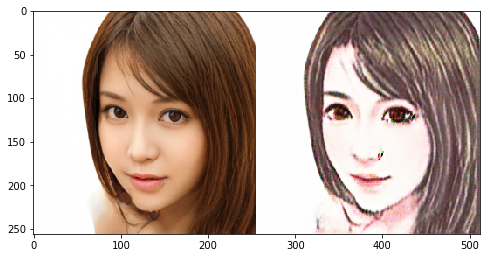

In [17]:
# 读取数据
test_names = os.listdir('data/cartoon_A2B/test')
img_name = np.random.choice(test_names)
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, :256]                                  # 真人照
img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()